In [1]:

# importing packages

%matplotlib notebook
import matplotlib.pyplot as plt;
plt.style.use('classic')
import numpy as np
from pyDOE import lhs #<-- Latin hypercube

import random
from scipy.interpolate import griddata


from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import initializers

import tensorflow as tf

Using TensorFlow backend.


In [3]:
# importing data as numpy arrays
time=np.load("tt.npy")
zz=np.load("zz.npy")

In [4]:
# more numpy arrays
X0=np.load("X0.npy")
Y0=np.load("Y0.npy")
Bav=np.load("Bav.npy")

# variables to define shape of said arrays
X1=np.zeros(np.shape(X0))
Y1=np.zeros([len(Y0),1])

# normalizing data to help reduce time of rendering
X1[:,0]=(X0[:,0]-np.mean(X0[:,0]))/np.std(X0[:,0])
X1[:,1]=(X0[:,1]-np.mean(X0[:,1]))/np.std(X0[:,1])


Y1[:,0]=(Y0-np.mean(Y0))/np.std(Y0)


# Arrange data to be evenly spaced
myindex=np.arange(0,len(X1))
np.random.shuffle(myindex)

X0=X0[myindex,:]
Y0=Y0[myindex]

X1=X1[myindex,:]
Y1=Y1[myindex,:]

<IPython.core.display.Javascript object>


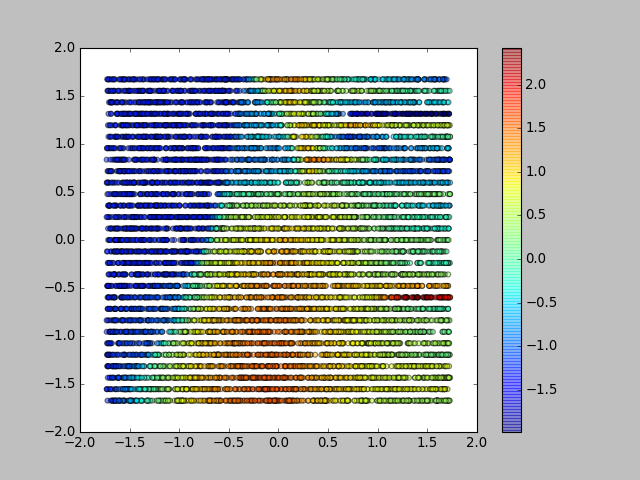

In [5]:
# plotting the data
NN=10000
list_of_random = random.sample(list(myindex), NN)


plt.figure(123);plt.clf()
plt.scatter(X1[list_of_random,0],X1[list_of_random,1],c=Y1[list_of_random,0],cmap='jet',alpha=0.5,marker='o')

plt.colorbar()
#plt.clim(-1,1)

In [6]:
Y1.shape

(145000, 1)

In [7]:
span=10

X11=np.zeros([len(X1),2*span])
Y11=np.zeros(np.shape(X11))

print(X11)
print(Y11)

for jj in range(0,span):
    X11[:,2*jj:2*jj+2]=X1
    Y11[:,2*jj]=Y1[:,0]
    Y11[:,2*jj+1]=Y1[:,0]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [8]:
from keras import backend as K
def swish(x):
    return x * K.sigmoid(x)

# Where did you get these constants for loss function?

def swishn(x):
    return 1.78718727865 * (x * K.sigmoid(x) - 0.20662096414)

In [9]:
myActiv='relu'
# myActiv='softplus'
#myActiv='elu'
#myActiv=swishn
#myActiv='selu'
myNumInner=30

# batch size? (smaller for more datasets and)
myWinner=10#span*2

#myInit=initializers.Orthogonal(gain=1.0, seed=None)
#myInit=initializers.he_uniform(seed=None)
#myInit=initializers.he_normal(seed=None)
#myInit=initializers.lecun_uniform(seed=None)

#myInit=initializers.lecun_normal(seed=None)

#myInit=initializers.RandomNormal(mean=0.0, stddev=1.0e-4, seed=None)
myInit=initializers.glorot_normal(seed=None)
# define the keras model
#myInit="normal"
model = Sequential()

Bias_yes=True
#model.add(Dense(myWinner, input_dim=10, activation='linear',kernel_initializer=initializers.Constant(value=np.sqrt(50)/myWinner)))
#model.add(Dense(myWinner, input_dim=span*2, activation='linear',kernel_initializer=myInit,use_bias=Bias_yes))
model.add(Dense(myWinner, input_dim=2, activation='linear',kernel_initializer=myInit,use_bias=Bias_yes))
for jj in range(0, myNumInner-1):
    model.add(Dense(myWinner, activation=myActiv,kernel_initializer=myInit,use_bias=Bias_yes))

#model.add(Dense(myWinner, activation='linear',kernel_initializer=myInit))
#model.add(Dense(1, activation='linear',kernel_initializer=myInit))        
#model.add(Dense(1, activation='linear',kernel_initializer=initializers.Constant(value=1/myWinner)))
#model.add(Dense(span*2, activation='linear',kernel_initializer=myInit,use_bias=Bias_yes))
model.add(Dense(1, activation='linear',kernel_initializer=myInit,use_bias=Bias_yes))

model.summary()

big_history=np.array([])

print(big_history)



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

In [10]:
# Receiving values for weights of layers?

W,L =model.layers[0].get_weights()

In [11]:
print(np.sum(W[:,6]**2))

print(np.sum(W[:,2])/(2*span))

0.020418659
-0.01798180639743805


In [14]:
# Actual model compiling

myLR=0.001
my_optimizer=optimizers.Adam(lr=myLR, beta_1=0.9, beta_2=0.999, amsgrad=True)
#my_optimizer=optimizers.RMSprop(lr=0.00002, rho=0.9)
#my_optimizer=optimizers.Adadelta(lr=1.0, rho=0.95)
#my_optimizer=optimizers.SGD(lr=2e-3, momentum=0.01, nesterov=False)
model.compile(loss='mse', optimizer=my_optimizer, metrics=['mse'])
#loss = tf.keras.losses.Huber(delta=1.0)
#model.compile(loss='huber', optimizer=my_optimizer, metrics=['accuracy'])
#model.compile(loss='mae', optimizer=my_optimizer, metrics=['accuracy'])
#model.compile(loss=loss, optimizer=my_optimizer, metrics=['mean_absolute_error'])
#model.compile(loss='logcosh', optimizer=my_optimizer, metrics=['accuracy'])


In [16]:
## fit the keras model on the dataset
#model.fit(Xall, Yall, epochs=10000, batch_size=int(len(Xall)/4),shuffle=True)
#model.fit(Xf, Yf, epochs=1000, batch_size=int(len(Xf/2)),shuffle=True)#
history=model.fit(X1, Y1, epochs=200, batch_size=5000,shuffle=True,validation_split=0.05)

big_history=np.hstack([big_history,history.history['loss']])

Train on 137750 samples, validate on 7250 samples
Epoch 1/200
137750/137750 [==============================] - 2s 12us/step - loss: 0.4348 - mse: 0.4348 - val_loss: 0.4094 - val_mse: 0.4094
Epoch 2/200
137750/137750 [==============================] - 1s 10us/step - loss: 0.3907 - mse: 0.3907 - val_loss: 0.3663 - val_mse: 0.3663
Epoch 3/200
137750/137750 [==============================] - 2s 13us/step - loss: 0.3470 - mse: 0.3470 - val_loss: 0.3247 - val_mse: 0.3247
Epoch 4/200
137750/137750 [==============================] - 2s 11us/step - loss: 0.3077 - mse: 0.3077 - val_loss: 0.2846 - val_mse: 0.2846
Epoch 5/200
137750/137750 [==============================] - 1s 10us/step - loss: 0.2703 - mse: 0.2703 - val_loss: 0.2531 - val_mse: 0.2531
Epoch 6/200
137750/137750 [==============================] - 2s 11us/step - loss: 0.2397 - mse: 0.2397 - val_loss: 0.2236 - val_mse: 0.2236
Epoch 7/200
137750/137750 [==============================] - 1s 10us/step - loss: 0.2123 - mse: 0.2123 - val_l

Epoch 59/200
137750/137750 [==============================] - 1s 10us/step - loss: 0.0654 - mse: 0.0654 - val_loss: 0.0656 - val_mse: 0.0656
Epoch 60/200
137750/137750 [==============================] - 1s 10us/step - loss: 0.0642 - mse: 0.0642 - val_loss: 0.0624 - val_mse: 0.0624
Epoch 61/200
137750/137750 [==============================] - 1s 10us/step - loss: 0.0648 - mse: 0.0648 - val_loss: 0.0660 - val_mse: 0.0660
Epoch 62/200
137750/137750 [==============================] - 1s 9us/step - loss: 0.0652 - mse: 0.0652 - val_loss: 0.0625 - val_mse: 0.0625
Epoch 63/200
137750/137750 [==============================] - 1s 9us/step - loss: 0.0644 - mse: 0.0644 - val_loss: 0.0623 - val_mse: 0.0623
Epoch 64/200
137750/137750 [==============================] - 1s 9us/step - loss: 0.0645 - mse: 0.0645 - val_loss: 0.0636 - val_mse: 0.0636
Epoch 65/200
137750/137750 [==============================] - 1s 9us/step - loss: 0.0654 - mse: 0.0654 - val_loss: 0.0605 - val_mse: 0.0605
Epoch 66/200
1377

137750/137750 [==============================] - 1s 9us/step - loss: 0.0472 - mse: 0.0472 - val_loss: 0.0473 - val_mse: 0.0473
Epoch 118/200
137750/137750 [==============================] - 2s 11us/step - loss: 0.0446 - mse: 0.0446 - val_loss: 0.0453 - val_mse: 0.0453
Epoch 119/200
137750/137750 [==============================] - 1s 9us/step - loss: 0.0427 - mse: 0.0427 - val_loss: 0.0427 - val_mse: 0.0427
Epoch 120/200
137750/137750 [==============================] - 1s 9us/step - loss: 0.0421 - mse: 0.0421 - val_loss: 0.0427 - val_mse: 0.0427
Epoch 121/200
137750/137750 [==============================] - 2s 12us/step - loss: 0.0418 - mse: 0.0418 - val_loss: 0.0442 - val_mse: 0.0442
Epoch 122/200
137750/137750 [==============================] - 1s 9us/step - loss: 0.0434 - mse: 0.0434 - val_loss: 0.0424 - val_mse: 0.0424
Epoch 123/200
137750/137750 [==============================] - 1s 9us/step - loss: 0.0413 - mse: 0.0413 - val_loss: 0.0420 - val_mse: 0.0420
Epoch 124/200
137750/1377

137750/137750 [==============================] - 1s 9us/step - loss: 0.0345 - mse: 0.0345 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 176/200
137750/137750 [==============================] - 2s 11us/step - loss: 0.0334 - mse: 0.0334 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 177/200
137750/137750 [==============================] - 2s 13us/step - loss: 0.0517 - mse: 0.0517 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 178/200
137750/137750 [==============================] - 1s 10us/step - loss: 0.0435 - mse: 0.0435 - val_loss: 0.0377 - val_mse: 0.0377
Epoch 179/200
137750/137750 [==============================] - 1s 9us/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 180/200
137750/137750 [==============================] - 1s 9us/step - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 181/200
137750/137750 [==============================] - 1s 9us/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 182/200
137750/137

In [17]:
# Saves model to specific file
model.save("Baverage5")

<IPython.core.display.Javascript object>


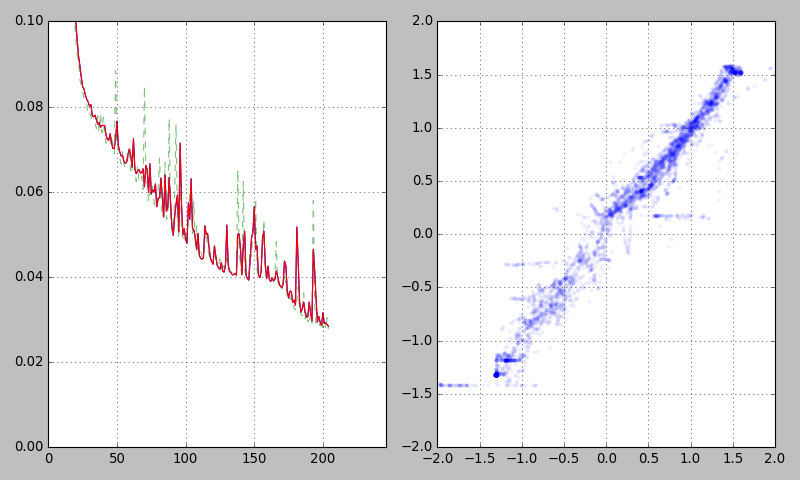

In [18]:
plt.figure(44,figsize=(10,6));plt.clf()
plt.subplot(1,2,1)

xlims1=(0,len(big_history)*1.2)
bbb=np.arange(0,len(history.history['loss']))


plt.plot(big_history)
plt.plot(bbb+len(big_history)-len(bbb),(history.history['val_loss']),'--',alpha=0.5)

plt.plot(bbb+len(big_history)-len(bbb),(history.history['loss']),'-')

plt.plot(0,0)
ymax=0.1
indsel=np.random.randint(0,len(X11),6000)

#Y_pred = np.mean(model.predict(X11[indsel,:]),axis=1)
#mumj=0
Y_pred = model.predict(X1[indsel,:])


#print(Yf[indsel[mumj],:])
plt.xlim(xlims1)

plt.ylim(0,ymax)
plt.grid()

#plt.plot(0,0)
plt.subplot(1,2,2)

plt.plot(Y1[indsel],Y_pred,'.',alpha=0.05)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.grid()
plt.tight_layout()


In [19]:
numnum=128

expand=1.0
xcent=0.0
ycent=0.0
#xrange=expand*np.array([xmin-xcent,xmax-xcent])
#trange=expand*np.array([tmin-ycent,tmax-ycent])

#xrange=(np.array([xmin-xcent,xmax-xcent])-meanXf)/stdXf
#trange=(np.array([tmin-ycent,tmax-ycent])-meanXf)/stdXf
xrange=np.array([np.min(X11[:,1]),np.max(X11[:,1])])
trange=np.array([np.min(X11[:,0]),np.max(X11[:,0])])

xx=expand*np.linspace(xrange[0]-xcent,xrange[1]-xcent,numnum)
tt=expand*np.linspace(trange[0]-ycent,trange[1]-ycent,numnum)

T,X = np.meshgrid(tt,xx)
X_star = np.hstack((T.flatten()[:,None],X.flatten()[:,None]))

X_star2=np.zeros([len(X_star),2*span])


for jj in range(0,span):
    X_star2[:,2*jj:2*jj+2]=X_star
#Y_star = np.mean(model.predict(X_star2),axis=1)
Y_star = model.predict(X_star)

Yp=np.zeros([numnum,numnum])
Yp=griddata(X_star, Y_star.flatten(), (T,X), method='cubic')

Yp[:,:]=Yp[::-1,:]

<IPython.core.display.Javascript object>


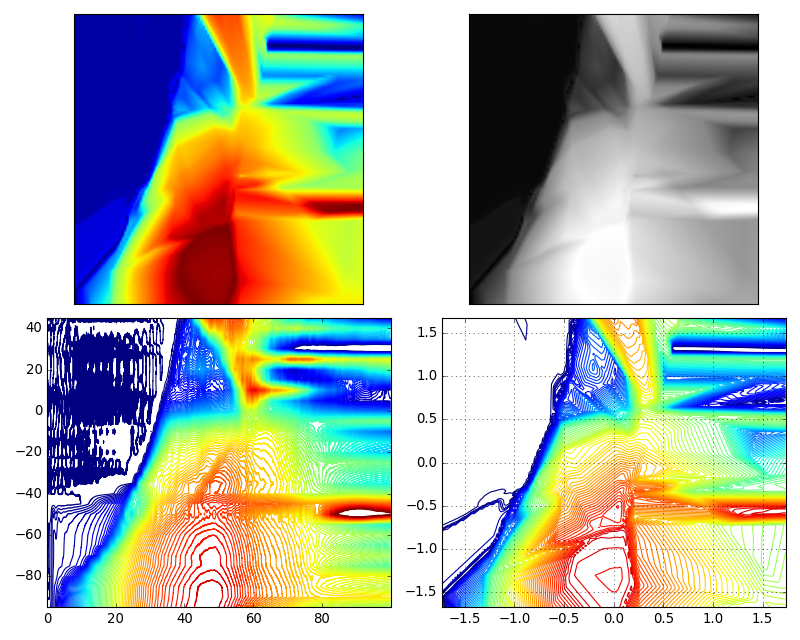

In [20]:
plt.figure(13,facecolor='none',figsize=(10,8));plt.clf()

plt.subplot(2,2,1)
#levels=np.linspace(plo.min(),plo.max(),251)

plt.imshow(Yp)
#plt.contour(xx,tt,plo.T,100,cmap='gray')
#fac=0.7
#plt.clim(fac*np.min(Yf),fac*np.max(Yf))
#plt.grid(color='white')
#plt.clim(0,2)
plt.xticks([])
plt.yticks([])


plt.subplot(2,2,2)

plt.imshow(Yp,cmap='gray')

plt.xticks([])
plt.yticks([])

plt.subplot(2,2,3)
levels=np.linspace(0,700,101)
plt.contour(time[1000:6000],zz,Bav,levels)
#plt.xticks([])
#plt.yticks([])


plt.subplot(2,2,4)
#levels=np.linspace(-2,2,51)
#plt.contour(tt*np.std(X0[:,0])+np.mean(X0[:,0]),xx*np.std(X0[:,1])+np.mean(X0[:,1]),Yp[::-1,:]*np.std(Y0)+np.mean(Y0),levels)
plt.contour(tt,xx,Yp[::-1,:]*np.std(Y0)+np.mean(Y0),levels)

lilx=np.linspace(-0.1,0.1,10)
#plt.plot(lilx,mmm*lilx)
#plt.xticks([])
#plt.yticks([])
plt.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


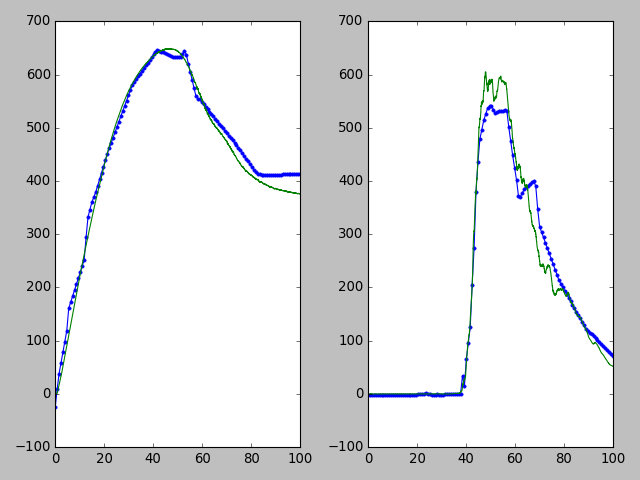

In [21]:
plt.figure(1232);plt.clf()

plt.subplot(1,2,1)
plt.plot(tt*np.std(X0[:,0])+np.mean(X0[:,0]),Yp[-1,:]*np.std(Y0)+np.mean(Y0),'.-')
plt.plot(time[1000:6000],Bav[0,:])


plt.subplot(1,2,2)
plt.plot(tt*np.std(X0[:,0])+np.mean(X0[:,0]),Yp[0,:]*np.std(Y0)+np.mean(Y0),'.-')
plt.plot(time[1000:6000],Bav[-1,:])

plt.tight_layout()

In [22]:

x_test_1 = np.zeros([500,2])
x_test_1[:,1]=0.87
x_test_1[:,0]=np.linspace(-1,0,500)

In [23]:
gradients = K.gradients(model.output, model.input)              #Gradient of output wrt the input of the model (Tensor)
print(gradients)

sess = K.get_session()

e_g_1 = sess.run(gradients[0], feed_dict={model.input: x_test_1})
#print(e_g_1)
#mmm=-e_g_1[0,0]/e_g_1[0,1]



[<tf.Tensor 'gradients/dense_1/MatMul_grad/MatMul:0' shape=(?, 2) dtype=float32>]


C:\Users\tbmh1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


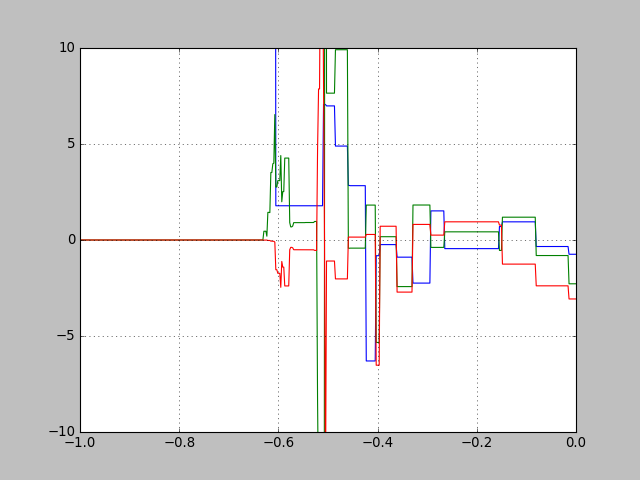

In [24]:

mvec=-e_g_1[:,0]/e_g_1[:,1]

plt.figure(1232111);plt.clf()

plt.plot(x_test_1[:,0],mvec,'-')
plt.plot(x_test_1[:,0],e_g_1[:,0],'-')
plt.plot(x_test_1[:,0],e_g_1[:,1],'-')

plt.ylim(-10,10)
plt.grid()
